Este script genera graficos de frecuencia instantanea de la DOE vs. tiempo durante el estimulo. Superpone cada estimulacion y las separa en sub-plots por hora consecutiva de estimulacion. Tiene la opcion de separar entre el trial de la mañana y la tarde.

Toma los archivos .pkl obtenidos de 'EOD_analysis.py' y los .csv registrados con bonsai con los timestamps de los on y off del objeto. Puede ser adaptado para graficar raster-plot, graficar todas las horas de estimulacion en uno y cambiar los rangos de tiempo de interes para plotear. 

In [124]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.stats import zscore

#cambiamos la carpeta de trabajo y cargamos los archivos
data_folder = r'D:\Datos G. omarorum\Fish5\Objeto\Trial 1 y 2\raw' #cambiar a ruta con archivos .bin
os.chdir(data_folder)

files_EOD = sorted(glob.glob('*.bin'))
#definimos parametros
sf = 10000


In [125]:
#cargamos el archivo de FB-DOE
with open('fish5_FB-DOE.pkl', 'rb') as file:   #cambiar al nombre apropiado de archivo
        FB_doe = pickle.load(file)

A continuacion tenemos algunas celdas que pre-procesan nuestros datos y filtran los archivos para solo utilizar los que contienen registros durante la estimulacion.

In [126]:
# generamos la lista files_start que contiene las timestamps en formato datetime del comienzo de cada uno de los archivos
files_start = [datetime.strptime(key[:-1], '%Y-%m-%dT%H_%M_%S') for key in sorted(FB_doe['FB-DOE'].keys())]
print(files_start)

[datetime.datetime(2024, 1, 31, 17, 7, 7), datetime.datetime(2024, 1, 31, 17, 27, 7), datetime.datetime(2024, 1, 31, 17, 47, 7), datetime.datetime(2024, 1, 31, 18, 7, 7), datetime.datetime(2024, 1, 31, 18, 27, 7), datetime.datetime(2024, 1, 31, 18, 47, 8), datetime.datetime(2024, 1, 31, 19, 7, 8), datetime.datetime(2024, 1, 31, 19, 27, 8), datetime.datetime(2024, 1, 31, 19, 47, 8), datetime.datetime(2024, 1, 31, 20, 7, 8), datetime.datetime(2024, 1, 31, 20, 27, 8), datetime.datetime(2024, 1, 31, 20, 47, 8), datetime.datetime(2024, 1, 31, 21, 7, 9), datetime.datetime(2024, 1, 31, 21, 27, 9), datetime.datetime(2024, 1, 31, 21, 47, 9), datetime.datetime(2024, 1, 31, 22, 7, 9), datetime.datetime(2024, 1, 31, 22, 27, 9), datetime.datetime(2024, 1, 31, 22, 47, 9), datetime.datetime(2024, 1, 31, 23, 7, 10), datetime.datetime(2024, 1, 31, 23, 27, 10), datetime.datetime(2024, 1, 31, 23, 47, 10), datetime.datetime(2024, 2, 1, 0, 7, 10), datetime.datetime(2024, 2, 1, 0, 27, 10), datetime.datetime

In [127]:
from datetime import datetime, timedelta

def generate_timestamps(start_date, hour1, delta):
    # Define the start and end times
    start_time = datetime(start_date.year, start_date.month, start_date.day, hour1, 0, 0)
    end_time = start_time + timedelta(hours=delta)  # 8 hours from 9 PM to 5 AM

    # Initialize an empty list to store timestamps
    timestamps = []

    # Generate timestamps at one-minute intervals
    current_time = start_time
    while current_time <= end_time:
        timestamps.append(current_time)
        current_time += timedelta(minutes=1)

    return timestamps

# Generamos las timestamps:
given_date = files_start[0] 
timestamps_obj = generate_timestamps(given_date, 17, 4)
timestamps_basal = generate_timestamps(given_date, 21, 8)


In [128]:
import random
from datetime import datetime, timedelta


# Function to randomly sample 60 timestamps
def sample_random_timestamps(timestamps, seed):
    # Ensure that we have at least 60 timestamps available
    if len(timestamps) < 60:
        raise ValueError("Not enough timestamps to sample from.")

    random.seed(seed)
    # Sample 60 timestamps randomly
    sampled_timestamps = random.sample(timestamps, 60)
    return sampled_timestamps

# Sample 60 random timestamps
random_timestamps_b = sorted(sample_random_timestamps(timestamps_basal, seed=123))
random_timestamps_o = sorted(sample_random_timestamps(timestamps_obj, seed=13))
del timestamps_basal, timestamps_obj

In [129]:
nueve = datetime(given_date.year, given_date.month, given_date.day, 21, 0, 0)
cinco = nueve + timedelta(hours=8) 

keys = [x for i, x in enumerate(sorted(FB_doe['FB-DOE'].keys())) if files_start[i] > nueve and files_start[i] < cinco]
k_idx = [i for i, x in enumerate(sorted(FB_doe['FB-DOE'].keys())) if files_start[i] > nueve and files_start[i] < cinco]
FB_DOE = {key: FB_doe['FB-DOE'][key] for key in keys}
Peak_time = {key: FB_doe['Peak-time'][key] for key in keys}# guardamos los peak-times en otra variable
n_files = len(keys)
del cinco, nueve

In [130]:
files_start = [files_start[x] for x in k_idx] #nos quedamos solo con los timestamps de los archivos de interes
files_start


[datetime.datetime(2024, 1, 31, 21, 7, 9),
 datetime.datetime(2024, 1, 31, 21, 27, 9),
 datetime.datetime(2024, 1, 31, 21, 47, 9),
 datetime.datetime(2024, 1, 31, 22, 7, 9),
 datetime.datetime(2024, 1, 31, 22, 27, 9),
 datetime.datetime(2024, 1, 31, 22, 47, 9),
 datetime.datetime(2024, 1, 31, 23, 7, 10),
 datetime.datetime(2024, 1, 31, 23, 27, 10),
 datetime.datetime(2024, 1, 31, 23, 47, 10),
 datetime.datetime(2024, 2, 1, 0, 7, 10),
 datetime.datetime(2024, 2, 1, 0, 27, 10),
 datetime.datetime(2024, 2, 1, 0, 47, 10),
 datetime.datetime(2024, 2, 1, 1, 7, 10),
 datetime.datetime(2024, 2, 1, 1, 27, 11),
 datetime.datetime(2024, 2, 1, 1, 47, 11),
 datetime.datetime(2024, 2, 1, 2, 7, 11),
 datetime.datetime(2024, 2, 1, 2, 27, 11),
 datetime.datetime(2024, 2, 1, 2, 47, 11),
 datetime.datetime(2024, 2, 1, 3, 7, 11),
 datetime.datetime(2024, 2, 1, 3, 27, 11),
 datetime.datetime(2024, 2, 1, 3, 47, 12),
 datetime.datetime(2024, 2, 1, 4, 7, 12),
 datetime.datetime(2024, 2, 1, 4, 27, 12),
 dateti

In [131]:
#organizamos cada on segun su archivo de registro
files = pd.DataFrame(np.zeros(shape=(20, n_files)), columns=sorted(keys))  # Usamos Int64Dtype para que pueda haber nans en columnas de int

for i, column in enumerate(files.columns[:-1], start=0):
    start = files_start[i]
    end = files_start[i+1]
    s = 0
    for j in range(1,len(random_timestamps_b)):
        condition = (start - random_timestamps_b[j]).total_seconds() < 0 and (end - random_timestamps_b[j]).total_seconds() > 0
        if condition:
            files.loc[s, column] = j
            s += 1

files = files.dropna(how='all')
files.replace(0, np.nan, inplace=True) # como inicializamos con una matriz de 0s, si hay algun archivo con menos de 5 ons vamos a tener 0s donde no deben haber, entonces los convertimos a nan
#files.iloc[0, 0] = 0 # el primer objeto tiene que ser un 0
files = files.dropna(how='all')
files = files.dropna(how='all', axis=1)

files

,2024-01-31T21_07_09.,2024-01-31T21_27_09.,2024-01-31T21_47_09.,2024-01-31T22_07_09.,2024-01-31T22_27_09.,2024-01-31T22_47_09.,2024-01-31T23_07_10.,2024-01-31T23_27_10.,2024-01-31T23_47_10.,2024-02-01T00_07_10.,...,2024-02-01T01_07_10.,2024-02-01T01_27_11.,2024-02-01T01_47_11.,2024-02-01T02_27_11.,2024-02-01T02_47_11.,2024-02-01T03_07_11.,2024-02-01T03_27_11.,2024-02-01T03_47_12.,2024-02-01T04_07_12.,2024-02-01T04_27_12.
0,2.0,7.0,10.0,13.0,17.0,18.0,19.0,22.0,25.0,29.0,...,38.0,39.0,41.0,43.0,44.0,45.0,46.0,49.0,51.0,55.0
1,3.0,8.0,11.0,14.0,NaN,NaN,20.0,23.0,26.0,30.0,...,NaN,40.0,42.0,NaN,NaN,NaN,47.0,50.0,52.0,56.0
2,4.0,9.0,12.0,15.0,NaN,NaN,21.0,24.0,27.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,53.0,57.0
3,5.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,58.0
4,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0


In [132]:
#inicializamos las listas
EOD_peaks_on = []
time_EOD_all  = []
time_obj_all = []
EOD_f_on = []

In [133]:
for k, key in enumerate(files.keys()): #loopeamos entre los archivos de interes
    midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[k],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+len(EOD)/sf, num=len(EOD))
    del EOD

    EOD_peaks = np.array(Peak_time[key])
    EOD_freq = np.array(FB_DOE[key])
    time_obj = np.zeros((files.shape[0]+1)) #inicializamos nuestra matriz de tiempo de prendida de obj (cada archivo puede tener maximo 5 ons, por eso las dimensiones)

    l=0
    for i in files.iloc[:,k]:
        if not np.isnan(i):
                s = abs(midnight - random_timestamps_b[int(i)]).total_seconds() #calculamos el inicio del on
                time_obj[l] = s
                time_obj_all.append(s) #guardamos el tiempo de este on en nuestra lista de tiempos de objeto
                time_EOD_all.append(time_EOD) #guardamos una copia de time_EOD para cada on 
                l+=1
    
    time_peaks = time_EOD[EOD_peaks]
    EOD_zscore = np.array(zscore(EOD_freq))
    del EOD_freq, time_EOD
    for j in range(time_obj.shape[0]):
        if not time_obj[j]==0:
            range_on = [time_obj[j]-.5, time_obj[j]+10] #definimos el rango de interes: 1/2 segundo antes que sea el on y 2 segundos despues
            #con = [range_on[0] <= t and t <= range_on[1] for t in videoTime]
            condition = [range_on[0] <= time and time <= range_on[1] for time in time_peaks]

            EOD_peaks_on.append(EOD_peaks[condition])
            EOD_f_on.append(EOD_zscore[condition[:-1]])
    del EOD_peaks, EOD_zscore, FB_DOE[key], Peak_time[key]

    print('termino archivo ' + str(k))

termino archivo 0
termino archivo 1
termino archivo 2
termino archivo 3
termino archivo 4
termino archivo 5
termino archivo 6
termino archivo 7
termino archivo 8
termino archivo 9
termino archivo 10
termino archivo 11
termino archivo 12
termino archivo 13
termino archivo 14
termino archivo 15
termino archivo 16
termino archivo 17
termino archivo 18
termino archivo 19
termino archivo 20
termino archivo 21


Las siguientes celdas contienen el codigo para generar las graficas. La primera genera la paleta de colores, la segunda genera el plot para todos los trials juntos y la tercera para los trials 1 y 2 separados

In [134]:
import matplotlib.cm as cm
colormap = cm.get_cmap('cool')
colors = [colormap(i+100) for i in range(len(time_obj_all))]

C:\Users\Compras\AppData\Local\Temp\ipykernel_19256\1860149869.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('cool')


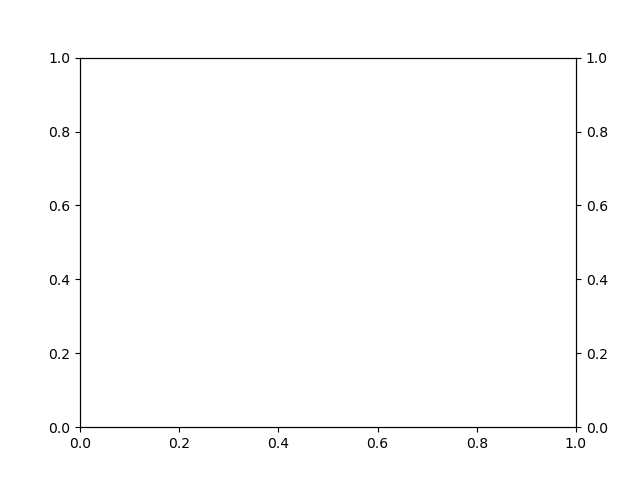

In [135]:
%matplotlib widget 
#plot all trials
n_per_on = []
t_novelty = []
trials = []
n_peaks = []
fig, ax = plt.subplots()
ax2 = ax.twinx()
k=0

EOD_zscore = EOD_f_on
    
if len(EOD_zscore)>0 :
    for z_score, peak, t, o, c in zip(EOD_zscore, EOD_peaks_on, time_EOD_all,  time_obj_all, colors):
        peak = peak[:len(z_score)]
        #plt.scatter(t[peak]-o, np.ones(len(peak))*k, color=c, s=1)
        i_novel = []
        novel = []
        for k in np.arange(1,len(z_score)-3):
            is_event = z_score[k] > 1.5 and z_score[k+1] > 1.5 and z_score[k+2] > 1.5 and z_score[k-1] < 1.5
            if is_event: 
                    i_novel.append(peak[k])    
                    novel.append(z_score[k]) 

        if len(peak) > 0:
            n_per_on.append(len(i_novel))
        else:
            n_per_on.append(0)

        n_peaks.append(len(peak))
        t_novelty.append(o)
        trials.append(k)
        #plt.scatter(t[i_novel]-o, np.ones(len(i_novel))*k, color=c, s=3)
        #k += .01

        #ax.set_ylabel('Ventanas de 10 s basal')
        #ax.set_xlabel('Tiempo (s)')


#bar_width = .01
#for i, y in zip(trials,n_per_on):
 #   bar_position = 10 -y +2
  #  ax2.barh(i + bar_width*i, y, height=bar_width, color='k', alpha=.5, left=bar_position)  # Bar for each line

#hours = [int(trial // 3600) for trial in t_novelty]
#minutes = [int(trial % 3600) // 60 for trial in t_novelty]
#dates = [datetime.now().replace(hour=hour, minute=minute, second=0, microsecond=0) for hour, minute in zip(hours, minutes)]

#ax.set_yticks([])

#ax.set_xticks([0,2,4,6,8,10])
#ax.set_xticklabels([0, 2,4,6,8,10])
#ax2.axvline(x=11, color='b', linestyle='--',alpha=.8, label='Vertical Line')

#x_hist = ax.secondary_xaxis('top')
#x_hist.set_xticks([11])
#x_hist.set_xticklabels(['100%'])
#ax2.set_yticks(np.linspace(0,k,len(trials)))
#ax2.set_yticklabels([date.strftime("%H:%M") for date in dates], fontsize=8)

#ax2.set_ylabel('Tiempo de comienzo de ventana')
plt.show()


In [136]:
p = sum([x*y for x,y in zip(n_per_on, n_peaks)])/len(n_per_on)
p*100

50370.68965517241

In [137]:
len(n_per_on)

58

In [138]:
prob = 0
for x in n_per_on:
    if x >0: 
        prob += 1

prob = prob / len(n_per_on) 
prob*100

29.310344827586203